## Downloading the JoJoGAN GitHub Repo to local machine

- Downloading GitHub Repo
- Ninja-linux package

In [1]:
# #@title Setup. This will take a few minutes.
!git clone https://github.com/mchong6/JoJoGAN.git
%cd JoJoGAN
!pip install tqdm gdown scikit-learn==0.22 scipy lpips dlib opencv-python wandb
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%load_ext autoreload
%autoreload 2"

Cloning into 'JoJoGAN'...
remote: Enumerating objects: 490, done.
remote: Total 490 (delta 0), reused 0 (delta 0), pack-reused 490
Receiving objects: 100% (490/490), 63.51 MiB | 13.77 MiB/s, done.
Resolving deltas: 100% (203/203), done.
/content/JoJoGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 15.1 MB/s 
     |████████████████████████████████| 53 kB 2.7 MB/s 
     |████████████████████████████████| 1.8 MB 51.0 MB/s 
     |████████████████████████████████| 181 kB 57.6 MB/s 
     |████████████████████████████████| 156 kB 65.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=088636851a5ef0c3ff128160d86c7ac81599b9f93f8dc7f84e107c389a707ed0
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Attempting

# Importing required Python Modules

In [2]:
import torch
from torchvision import transforms, utils
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import wandb

## Setting Cudnn benchmark usage for PyTorch

In [3]:
torch.backends.cudnn.benchmark = True

## Imprting JoJoGAN Specific Python Modules
- These modules are loaded from the JoJoGAN GitHub repo code (local file system)

In [4]:
# JoJoGAN Specific Import
from model import *
from e4e_projection import projection as e4e_projection
from util import *

## Python DeepCopy
The difference between shallow and deep copying is only relevant for compound objects (objects that contain other objects, like lists or class instances):

- A shallow copy constructs a new compound object and then (to the extent possible) inserts references into it to the objects found in the original.
- A deep copy constructs a new compound object and then, recursively, inserts copies into it of the objects found in the original.


In [5]:
from copy import deepcopy

## Creating local folders for local content creation and management

In [6]:
os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Downloading 68 Shape Predictor DLIB Model to read faces from the source images
- shape_predictor_68_face_landmarks.dat.bz2

In [7]:
# @title Download models

!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat models/dlibshape_predictor_68_face_landmarks.dat
%matplotlib inline


--2022-08-02 00:30:35--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  13.0MB/s    in 6.6s    

2022-08-02 00:30:42 (9.26 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [8]:
!ls -lah /content/JoJoGAN/models

total 96M
drwxr-xr-x  2 root root 4.0K Aug  2 00:30 .
drwxr-xr-x 12 root root 4.0K Aug  2 00:30 ..
-rw-r--r--  1 root root  96M Jul 24  2015 dlibshape_predictor_68_face_landmarks.dat


## Various Face Style JoJoGAN specific prebuilt models definition

In [9]:
drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
    "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
    "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
    "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
    "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
    "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
    "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
    "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
    "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
    "sketch_multi.pt": "1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD",
    "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
    "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
    "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
    "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
    "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
    "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
    "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
}

# **Google Colab Dependency**

Use the following if you would want to use this code in Google Colab and use Google Drive Authentication 

In [10]:
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# #@markdown You may optionally enable downloads with pydrive in order to authenticate and avoid drive download limits.
download_with_pydrive = True #@param {type:"boolean"}    


In [ ]:
# from StyelGAN-NADA
class GDrive_Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_name):
        file_dst = os.path.join('models', file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            if self.use_pydrive:
                downloaded = self.drive.CreateFile({'id':file_id})
                downloaded.FetchMetadata(fetch_all=True)
                downloaded.GetContentFile(file_dst)
            else:
                !gdown --id $file_id -O $file_dst

In [ ]:
#downloader = Downloader(download_with_pydrive)
downloader = GDrive_Downloader()
downloader.download_file('stylegan2-ffhq-config-f.pt')
downloader.download_file('e4e_ffhq_encode.pt')

# Downloading Models without Google Colab Dependency

In [11]:
# from StyelGAN-NADA
class Downloader(object):
    def download_file(self, file_name):
        file_dst = os.path.join('models', file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            !gdown --id $file_id -O $file_dst

In [12]:
downloader = Downloader()
downloader.download_file('stylegan2-ffhq-config-f.pt')
downloader.download_file('e4e_ffhq_encode.pt')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK
To: /content/JoJoGAN/models/stylegan2-ffhq-config-f.pt
100% 381M/381M [00:06<00:00, 62.1MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7
To: /content/JoJoGAN/models/e4e_ffhq_encode.pt
100% 1.20G/1.20G [00:24<00:00, 49.2MB/s]


In [13]:
!ls -lah /content/JoJoGAN/models/

total 1.6G
drwxr-xr-x  2 root root 4.0K Aug  2 00:31 .
drwxr-xr-x 12 root root 4.0K Aug  2 00:30 ..
-rw-r--r--  1 root root  96M Jul 24  2015 dlibshape_predictor_68_face_landmarks.dat
-rw-r--r--  1 root root 1.2G Aug  2 00:31 e4e_ffhq_encode.pt
-rw-r--r--  1 root root 364M Aug  2 00:31 stylegan2-ffhq-config-f.pt


## Making sure to use CUDA as GPU device 
- Please change it to CPU if you dont have GPU

In [14]:
device = 'cuda' #@param ['cuda', 'cpu']

## Loading StyleGAN model
- Already trained using FFHQ dataset - 70K faces
- https://github.com/NVlabs/ffhq-dataset

In [15]:
latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)

transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

## Source Image Setup to extract Face
- Extract Face from source
- 

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


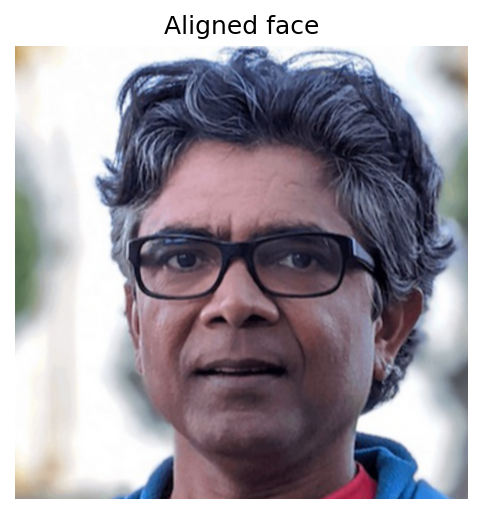

In [16]:
plt.rcParams['figure.dpi'] = 150

#@title Choose input face
#@markdown Add your own image to the test_input directory and put the name here
#filename = 'iu.jpeg' #@param {type:"string"}

filename = 'avkash.jpg' #@param {type:"string"}

filepath = f'test_input/{filename}'


# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face from the source image
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

display_image(aligned_face, title='Aligned face')

In [25]:
plt.rcParams['figure.dpi'] = 150
pretrained = 'sketch_multi' #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney']
#@markdown Preserve color tries to preserve color of original image by limiting family of allowable transformations. Otherwise, the stylized image will inherit the colors of the reference images, leading to heavier stylizations.
preserve_color = True #@param{type:"boolean"}

if preserve_color:
    ckpt = f'{pretrained}_preserve_color.pt'
else:
    ckpt = f'{pretrained}.pt'

# load base version if preserve_color version not available
try:
    downloader.download_file(ckpt)
except:
    ckpt = f'{pretrained}.pt'
    downloader.download_file(ckpt)

#@title Generate results
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD
To: /content/JoJoGAN/models/sketch_multi.pt
100% 133M/133M [00:02<00:00, 48.5MB/s]


In [26]:
!ls -lah /content/JoJoGAN/models/

total 1.9G
drwxr-xr-x  2 root root 4.0K Aug  2 00:39 .
drwxr-xr-x 12 root root 4.0K Aug  2 00:30 ..
-rw-r--r--  1 root root 127M Aug  2 00:35 disney_preserve_color.pt
-rw-r--r--  1 root root  96M Jul 24  2015 dlibshape_predictor_68_face_landmarks.dat
-rw-r--r--  1 root root 1.2G Aug  2 00:31 e4e_ffhq_encode.pt
-rw-r--r--  1 root root 127M Aug  2 00:39 sketch_multi.pt
-rw-r--r--  1 root root 364M Aug  2 00:31 stylegan2-ffhq-config-f.pt


In [27]:
ckpt = torch.load(os.path.join('models', ckpt), map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g"], strict=False)

<All keys matched successfully>

In [28]:
torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

/content/JoJoGAN/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.12.0+cu113. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."


In [29]:
# display reference images
if pretrained == 'arcane_multi':
    style_path = f'style_images_aligned/arcane_jinx.png'
elif pretrained == 'sketch_multi':
    style_path = f'style_images_aligned/sketch.png'
else:   
    style_path = f'style_images_aligned/{pretrained}.png'

In [30]:
style_image = transform(Image.open(style_path)).unsqueeze(0).to(device)
face = transform(aligned_face).unsqueeze(0).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


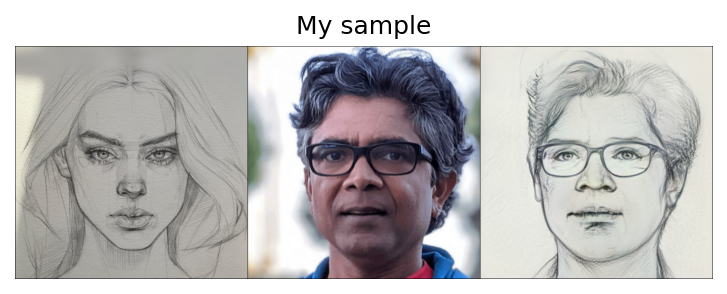

In [31]:
my_output = torch.cat([style_image, face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


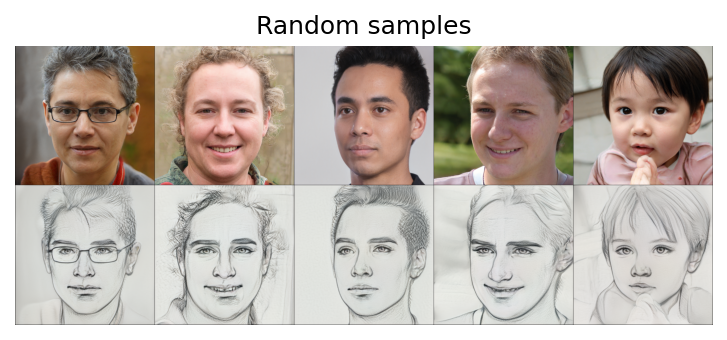

In [32]:
output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')

# Creating your own style
- Copy your style images into the style_images Folder

In [61]:
# #@markdown Upload your own style images into the style_images folder and type it into the field in the following format without the directory name. Upload multiple style images to do multi-shot image translation
# names =  ['hulk-01.jpg', 'hulk-04.jpg']#@param {type:"raw"}
# names =  ['drstrange-01.jpg', 'drstrange-02.jpg', 'drstrange-03.jpg', 'drstrange-04.jpg']#@param {type:"raw"}
names =  ['chimp.jpg']#@param {type:"raw"}
targets = []
latents = []

## Latent Space Creation from the Style(s)

In [62]:
for name in names:
    style_path = os.path.join('style_images', name)
    assert os.path.exists(style_path), f"{style_path} does not exist!"

    name = strip_path_extension(name)

    # crop and align the face
    style_aligned_path = os.path.join('style_images_aligned', f'{name}.png')
    if not os.path.exists(style_aligned_path):
        style_aligned = align_face(style_path)
        style_aligned.save(style_aligned_path)
    else:
        style_aligned = Image.open(style_aligned_path).convert('RGB')

    # GAN invert
    style_code_path = os.path.join('inversion_codes', f'{name}.pt')
    if not os.path.exists(style_code_path):
        latent = e4e_projection(style_aligned, style_code_path, device)
    else:
        latent = torch.load(style_code_path)['latent']

    targets.append(transform(style_aligned).to(device))
    latents.append(latent.to(device))

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


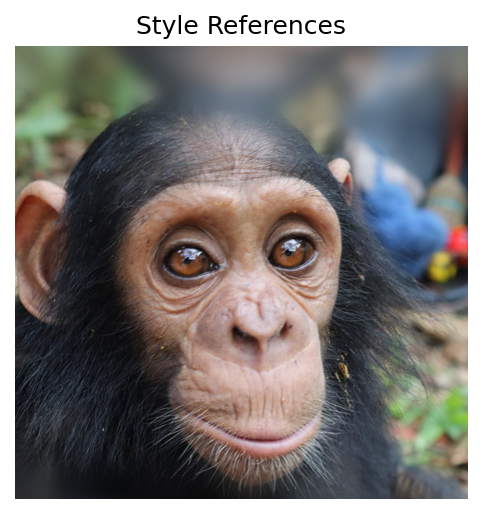

In [63]:
targets = torch.stack(targets, 0)
latents = torch.stack(latents, 0)

target_im = utils.make_grid(targets, normalize=True, range=(-1, 1))
display_image(target_im, title='Style References')

In [44]:
#@title Finetune StyleGAN
#@markdown alpha controls the strength of the style
alpha =  1.0 #@param {type:"slider", min:0, max:1, step:0.1}
alpha = 1-alpha

#@markdown Tries to preserve color of original image by limiting family of allowable transformations. Set to false if you want to transfer color from reference image. This also leads to heavier stylization
preserve_color = True #@param{type:"boolean"}
#@markdown Number of finetuning steps. Different style reference may require different iterations. Try 200~500 iterations.
num_iter = 500 #@param {type:"number"}
#@markdown Log training on wandb and interval for image logging
use_wandb = False #@param {type:"boolean"}
log_interval = 50 #@param {type:"number"}

if use_wandb:
    wandb.init(project="JoJoGAN")
    config = wandb.config
    config.num_iter = num_iter
    config.preserve_color = preserve_color
    wandb.log(
    {"Style reference": [wandb.Image(transforms.ToPILImage()(target_im))]},
    step=0)

# load discriminator for perceptual loss
discriminator = Discriminator(1024, 2).eval().to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
discriminator.load_state_dict(ckpt["d"], strict=False)

# reset generator
del generator
generator = deepcopy(original_generator)

g_optim = optim.Adam(generator.parameters(), lr=2e-3, betas=(0, 0.99))

# Which layers to swap for generating a family of plausible real images -> fake image
if preserve_color:
    id_swap = [9,11,15,16,17]
else:
    id_swap = list(range(7, generator.n_latent))

for idx in tqdm(range(num_iter)):
    mean_w = generator.get_latent(torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, generator.n_latent, 1)
    in_latent = latents.clone()
    in_latent[:, id_swap] = alpha*latents[:, id_swap] + (1-alpha)*mean_w[:, id_swap]

    img = generator(in_latent, input_is_latent=True)

    with torch.no_grad():
        real_feat = discriminator(targets)
    fake_feat = discriminator(img)

    loss = sum([F.l1_loss(a, b) for a, b in zip(fake_feat, real_feat)])/len(fake_feat)
    
    if use_wandb:
        wandb.log({"loss": loss}, step=idx)
        if idx % log_interval == 0:
            generator.eval()
            my_sample = generator(my_w, input_is_latent=True)
            generator.train()
            my_sample = transforms.ToPILImage()(utils.make_grid(my_sample, normalize=True, range=(-1, 1)))
            wandb.log(
            {"Current stylization": [wandb.Image(my_sample)]},
            step=idx)

    g_optim.zero_grad()
    loss.backward()
    g_optim.step()

  0%|          | 0/500 [00:00<?, ?it/s]/content/JoJoGAN/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.12.0+cu113. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
100%|██████████| 500/500 [03:45<00:00,  2.22it/s]


In [45]:
#@title Generate results
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

# display reference images
style_images = []
for name in names:
    style_path = f'style_images_aligned/{strip_path_extension(name)}.png'
    style_image = transform(Image.open(style_path))
    style_images.append(style_image)


/content/JoJoGAN/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.12.0+cu113. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."


## Display Reference image

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


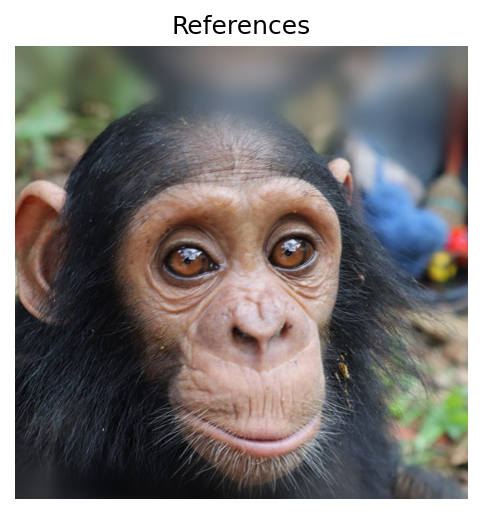

In [46]:
face = transform(aligned_face).to(device).unsqueeze(0)
style_images = torch.stack(style_images, 0).to(device)
display_image(utils.make_grid(style_images, normalize=True, range=(-1, 1)), title='References')

## Display Transformed image

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


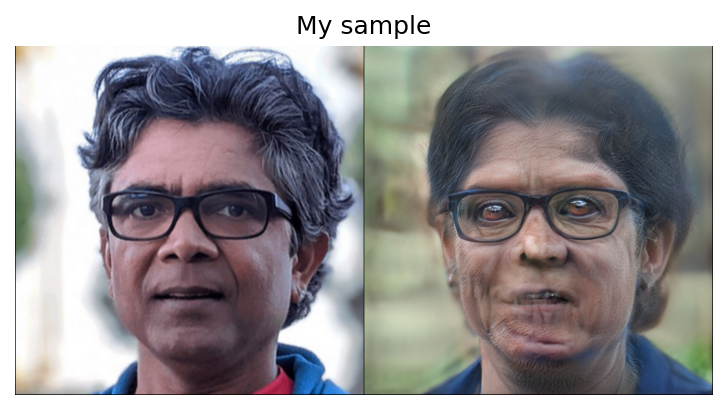

In [47]:
my_output = torch.cat([face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')

## Display Transformed images using Random Faces from the Faces Dataset

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


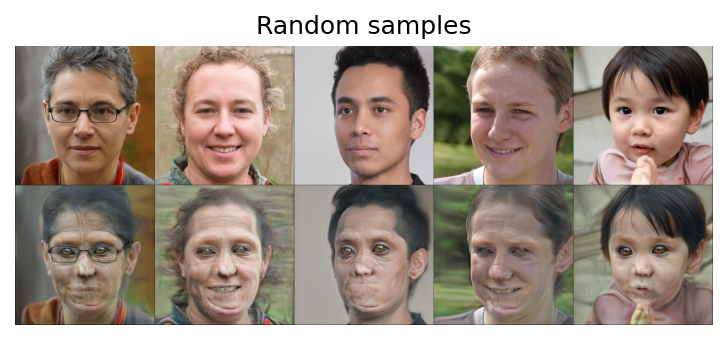

In [48]:
output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')